In [6]:
!pip install transformers datasets rouge-score accelerate

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=3635b7dcb801069ea107da4d4f037521f9468d5fa3ba1f7e1c6d17696c03ba2d
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score


## Environment & Setup —— Baseline Model

#### 1. Use baseline Model(FP32 baseline)

In [7]:
from transformers import BartTokenizer, BartForConditionalGeneration
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

### init model
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn").to(device)

print("Model loaded (FP32 baseline).")

Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

Model loaded (FP32 baseline).


#### 2. Load Dataset

In [8]:
from datasets import load_dataset

### Load dataset
dataset = load_dataset("abisee/cnn_dailymail", "3.0.0")

train_data = dataset["train"]
val_data   = dataset["validation"]
test_data  = dataset["test"]

train_data.to_csv("train.csv")
val_data.to_csv("val.csv")
test_data.to_csv("test.csv")

print("Dataset loaded:")
print("Train:", len(train_data))
print("Validation:", len(val_data))
print("Test:", len(test_data))

README.md: 0.00B [00:00, ?B/s]

3.0.0/train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

3.0.0/train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

3.0.0/train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

3.0.0/validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

3.0.0/test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Creating CSV from Arrow format:   0%|          | 0/288 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/14 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

Dataset loaded:
Train: 287113
Validation: 13368
Test: 11490


#### 3.⭐⭐⭐ Summarization Pipeline(重点研究)-(single request)

In [9]:
MAX_SUMMARY_LEN = 128
NUM_BEAMS = 4

def summarize(text, max_len=MAX_SUMMARY_LEN, num_beams=NUM_BEAMS):
    """
    Single-request summarization using model.generate.
    Returns a decoded string summary.
    """
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=1024
    ).to(device)
    with torch.no_grad():
        out_ids = model.generate(
            inputs["input_ids"],
            attention_mask=inputs.get("attention_mask", None),
            num_beams=num_beams,
            max_length=max_len,
            early_stopping=True
        )
    return tokenizer.decode(out_ids[0], skip_special_tokens=True)

#### 4. Build （Latency / Throughput / ROUGE） Tools

##### 4.1 ROUGE Scorer

In [10]:
from rouge_score import rouge_scorer

rouge = rouge_scorer.RougeScorer(['rouge1','rouge2','rougeL'], use_stemmer=True)

def eval_rouge(pred, ref):
    score = rouge.score(ref, pred)
    return {k: v.fmeasure for k, v in score.items()}


##### 4.2 Latency

In [11]:
import time

def measure_latency(text):
    start = time.time()
    _ = summarize(text)
    return time.time() - start

##### 4.3 Throughput

In [12]:
def measure_throughput(batch_texts):
    start = time.time()
    for text in batch_texts:
        summarize(text)
    total_time = time.time() - start
    return len(batch_texts) / total_time

#### Test: Prepare small test set

In [13]:
SAMPLE_NUM = 50
def get_samples(ds, n=SAMPLE_NUM):
    n = min(n, len(ds))
    return ds.select(range(n))

In [14]:
small_test = get_samples(test_data, SAMPLE_NUM)
print(f"[INFO] Using {len(small_test)} samples for baseline evaluation.")

[INFO] Using 50 samples for baseline evaluation.


#### 🌟🌟🌟 5.Bulid BaseLine

In [15]:
# baseLine
def run_baseline(dataset):
    results = []
    for item in dataset:
        article = item["article"]
        ref = item["highlights"]
        pred = summarize(article)
        results.append((pred, ref))
    return results

In [16]:
baseline_results = run_baseline(small_test)
print("Baseline inference finished.")

Baseline inference finished.


In [17]:
def evaluate_rouge_dataset(results):
    rouge1_scores, rouge2_scores, rougeL_scores = [], [], []
    for pred, ref in results:
        score = eval_rouge(pred, ref)
        rouge1_scores.append(score["rouge1"])
        rouge2_scores.append(score["rouge2"])
        rougeL_scores.append(score["rougeL"])

    return {
        "ROUGE-1": sum(rouge1_scores)/len(rouge1_scores),
        "ROUGE-2": sum(rouge2_scores)/len(rouge2_scores),
        "ROUGE-L": sum(rougeL_scores)/len(rougeL_scores),
    }

baseline_rouge = evaluate_rouge_dataset(baseline_results)
baseline_rouge

{'ROUGE-1': 0.35134095917031144,
 'ROUGE-2': 0.16079193053746807,
 'ROUGE-L': 0.2630955407146684}

In [18]:
import numpy as np

latencies = [measure_latency(item["article"]) for item in small_test]
baseline_latency = np.mean(latencies)
baseline_latency

np.float64(1.404372410774231)

In [19]:
texts = [item["article"] for item in small_test]
baseline_throughput = measure_throughput(texts)
baseline_throughput

0.7412108196198329

##### 6. Build  Baseline Report

6.1 记录 Baseline 指标

平均延迟（sec/request）

吞吐量（req/sec）

ROUGE-1/2/L 基线

生成一份 baseline 报告（供优化对照）

In [20]:
latencies = [measure_latency(item["article"]) for item in small_test]
baseline_latency = np.mean(latencies)
baseline_latency

texts = [item["article"] for item in small_test]
baseline_throughput = measure_throughput(texts)
baseline_throughput

baseline_rouge = evaluate_rouge_dataset(baseline_results)
baseline_rouge


np.float64(1.2612063026428222)

6.2 记录模型在不同输入长度下的性能

文章长度 vs latency 曲线

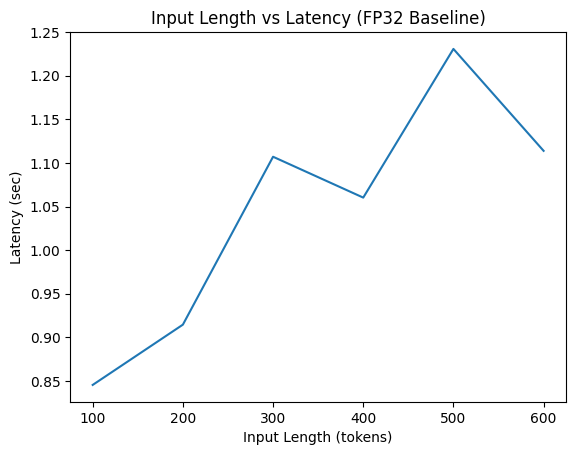

In [22]:
import matplotlib.pyplot as plt
length_buckets = [100, 200, 300, 400, 500, 600]

def get_by_length(ds, target_len, tol=30):
    samples = []
    for item in ds:
        if abs(len(tokenizer(item["article"])["input_ids"]) - target_len) < tol:
            samples.append(item["article"])
        if len(samples) >= 5:
            break
    return samples

bucket_latency = {}

for L in length_buckets:
    texts = get_by_length(test_data, L)
    lat = [measure_latency(t) for t in texts]
    bucket_latency[L] = np.mean(lat)
plt.plot(list(bucket_latency.keys()), list(bucket_latency.values()))
plt.xlabel("Input Length (tokens)")
plt.ylabel("Latency (sec)")
plt.title("Input Length vs Latency (FP32 Baseline)")
plt.show()



## Optimization Phase

执行 PTQ（Post-Training Quantization）

测试四种精度：

FP32（baseline）

FP16

INT8

INT4

动态批处理（Dynamic Batching）：在 batch size = 1,4,8,16 下测量延迟 / 吞吐 / ROUGE，并把量化与批处理结合比较。